In [19]:
%matplotlib inline
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn import metrics
from ggplot import *
from time import time
import operator
from tqdm import *

/home/local/VANDERBILT/remedis/anaconda3/envs/sam/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# loading datasets
DATA_DIR = os.path.join("data", "test")
PREPROCESSING_DIR = os.path.join(DATA_DIR, "preprocessed")
SEG_ROOT_DIR = os.path.join(DATA_DIR, "segmentations", "2018-10-22_21:48:59_unet_vumc_ssl_gantry_correction")

In [73]:
pred_filenames = [os.path.join(SEG_ROOT_DIR, x) for x in os.listdir(SEG_ROOT_DIR) 
                  if not os.path.isdir(os.path.join(SEG_ROOT_DIR, x))]
pred_filenames.sort()

gt_filenames = [os.path.join(PREPROCESSING_DIR, x) for x in os.listdir(PREPROCESSING_DIR) 
                  if not os.path.isdir(os.path.join(PREPROCESSING_DIR, x))]
gt_filenames = [x for x in gt_filenames if "mask" in x]
gt_filenames.sort()

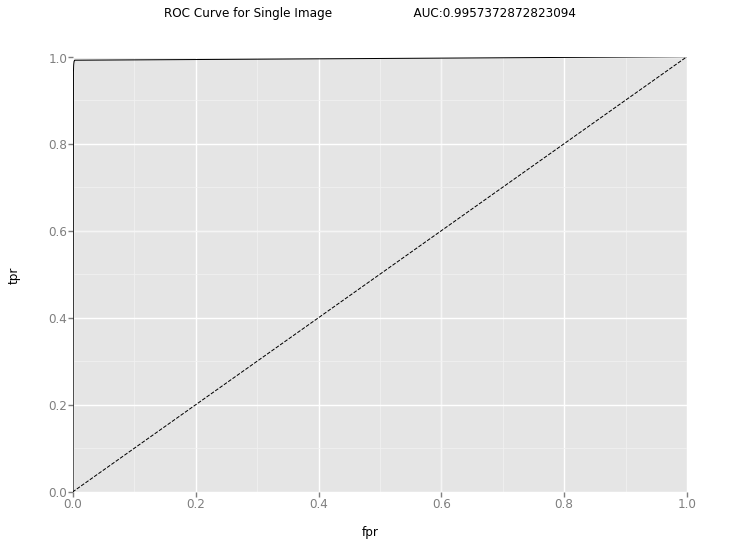

CQS_TBI10327_CT.nii.gz
AUC: 0.9957372872823094
Precision: 0.7472695500218436


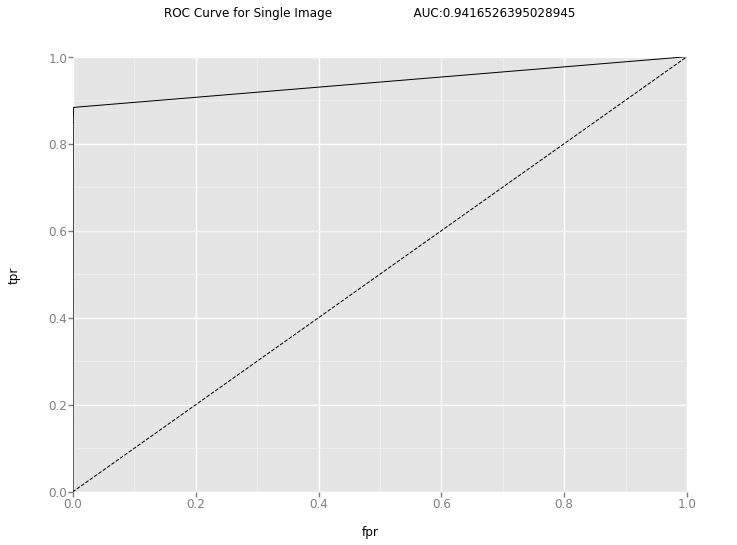

CQS_TBI10373_CT.nii.gz
AUC: 0.9416526395028945
Precision: 0.9816809689002495


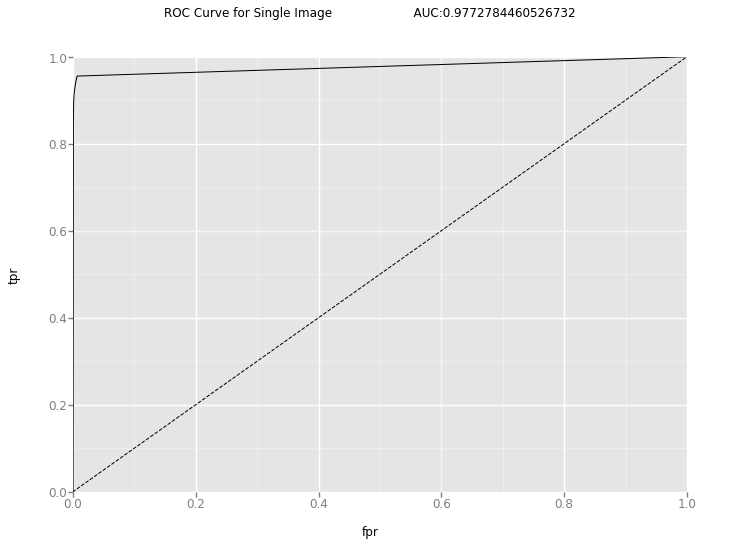

CQS_TBI10458_CT.nii.gz
AUC: 0.9772784460526732
Precision: 0.9534417566397886


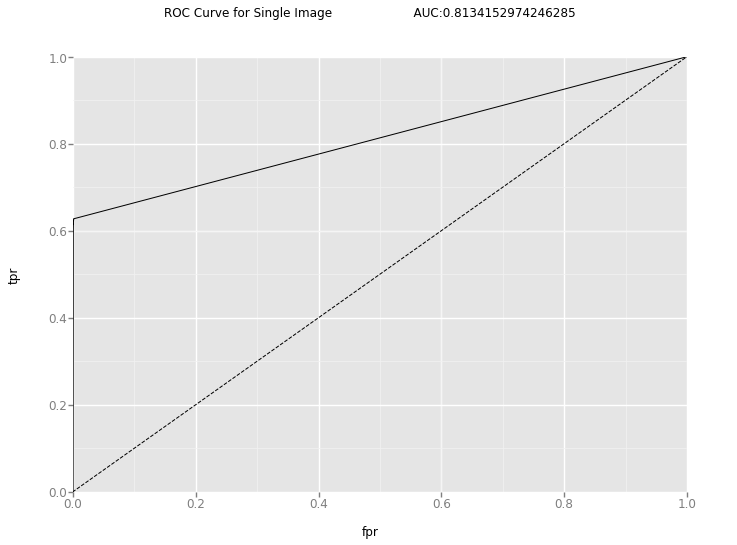

CQS_TBI10501_CT.nii.gz
AUC: 0.8134152974246285
Precision: 0.6665575916230366


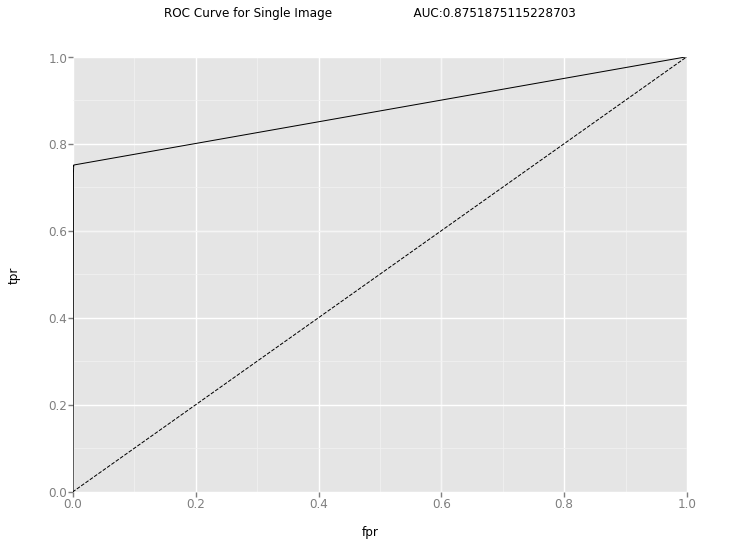

CQS_TBI10581_CT.nii.gz
AUC: 0.8751875115228703
Precision: 0.7094405594405594


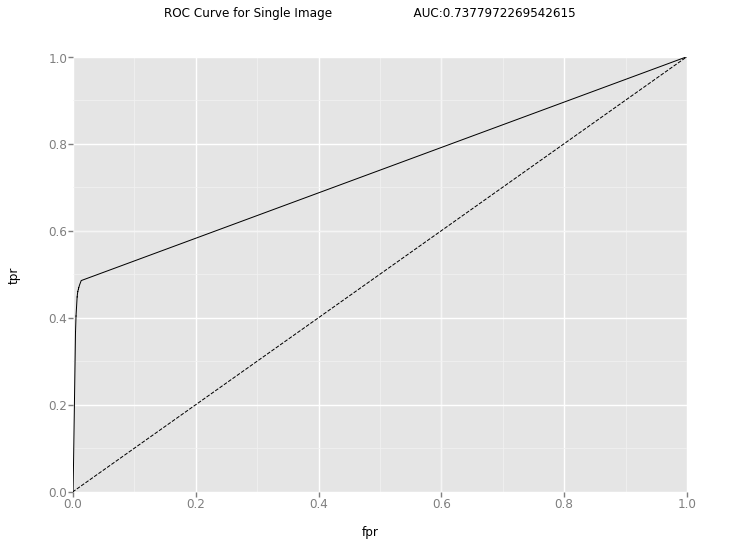

CQS_TBI10610_CT.nii.gz
AUC: 0.7377972269542615
Precision: 0.1721596555150712


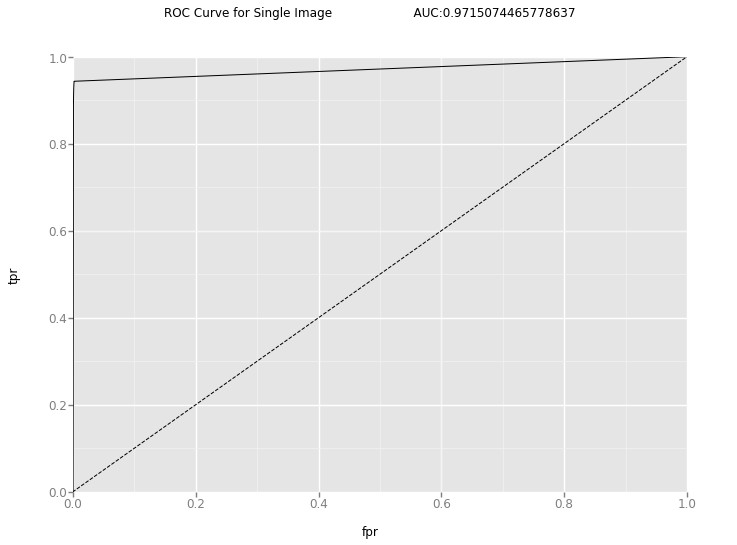

CQS_TBI10617_CT.nii.gz
AUC: 0.9715074465778637
Precision: 0.5799050632911392


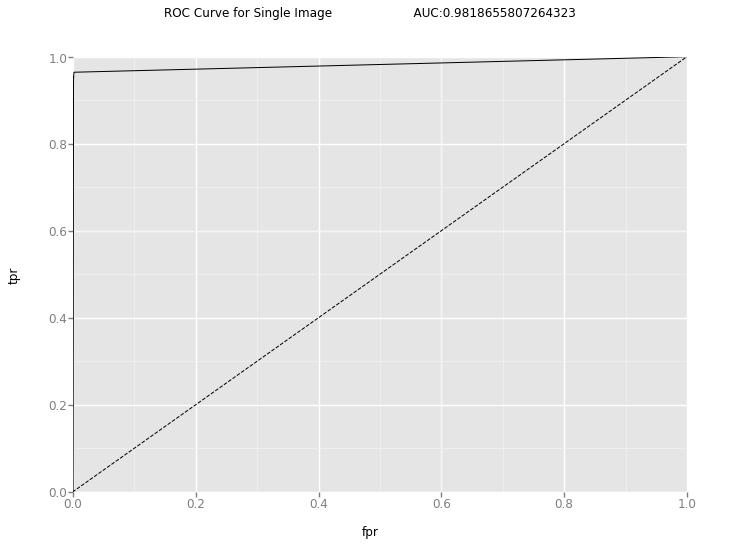

CQS_TBI10727_CT.nii.gz
AUC: 0.9818655807264323
Precision: 0.41700863166831753


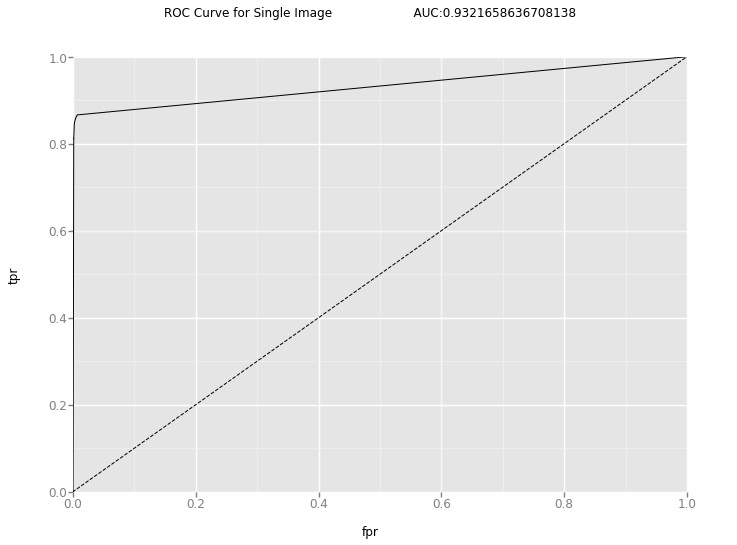

CQS_TBI10872_CT.nii.gz
AUC: 0.9321658636708138
Precision: 0.6634007585335019


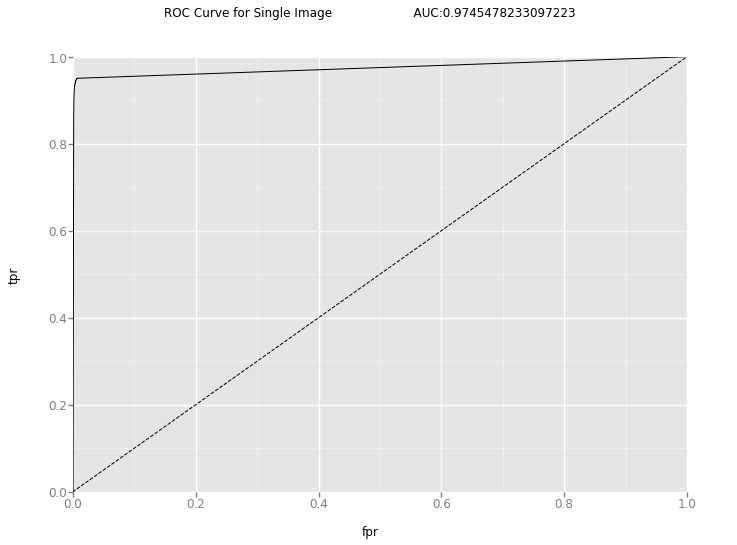

CQS_TBI10876_CT.nii.gz
AUC: 0.9745478233097223
Precision: 0.791599263680482


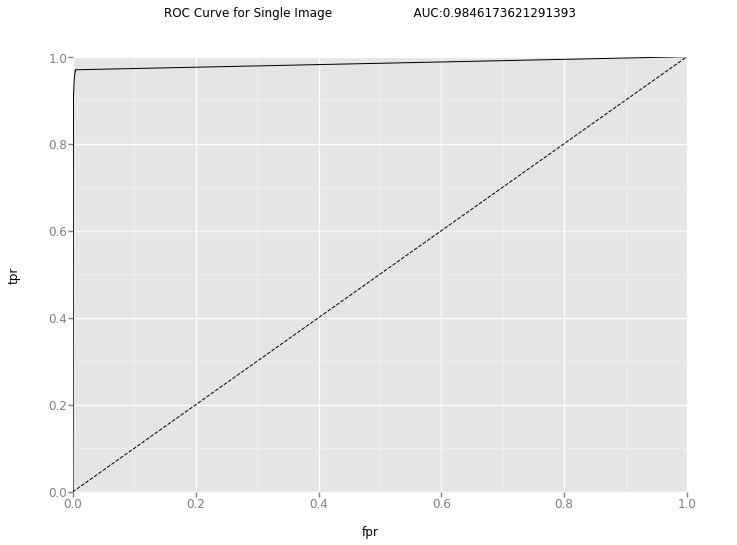

CQS_TBI10885_CT.nii.gz
AUC: 0.9846173621291393
Precision: 0.888851201502857


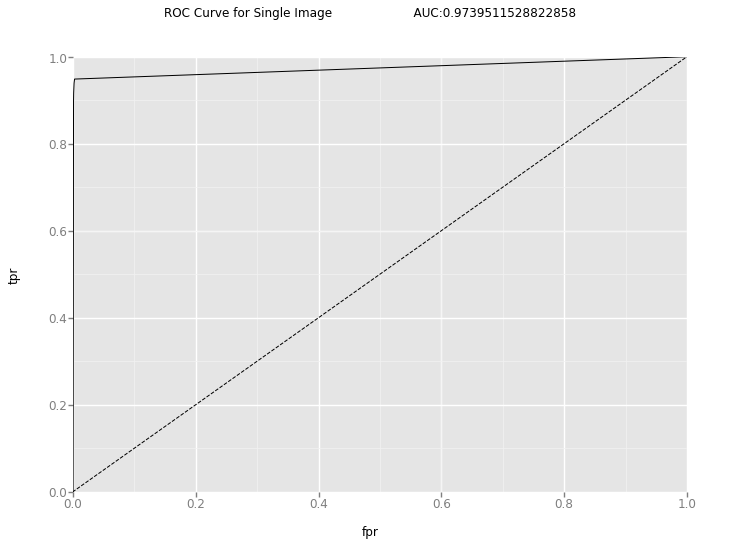

CQS_TBI11000_CT.nii.gz
AUC: 0.9739511528822858
Precision: 0.7536026972646691


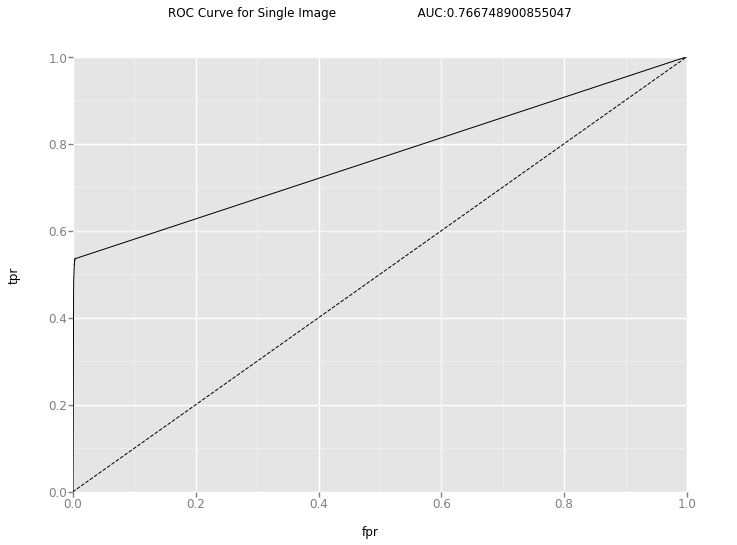

CQS_TBI11202_CT.nii.gz
AUC: 0.766748900855047
Precision: 0.5074363264547314


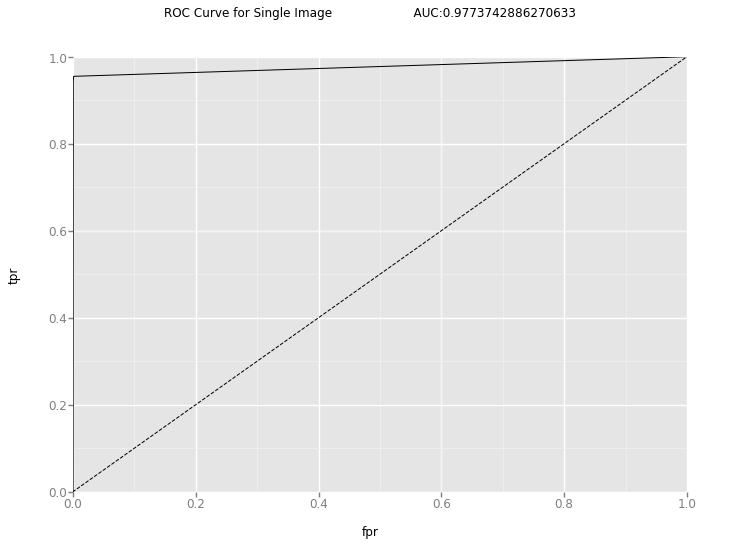

CQS_TBI11336_CT.nii.gz
AUC: 0.9773742886270633
Precision: 0.9512658227848101


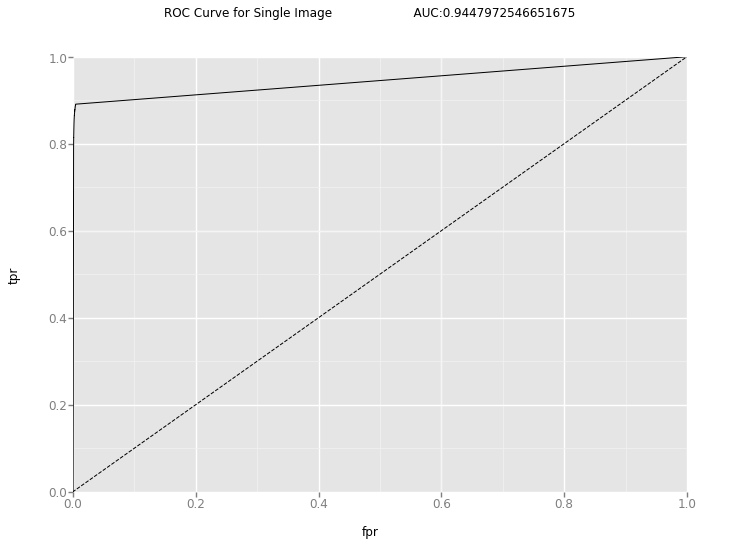

CQS_TBI11365_CT.nii.gz
AUC: 0.9447972546651675
Precision: 0.9090960166301477


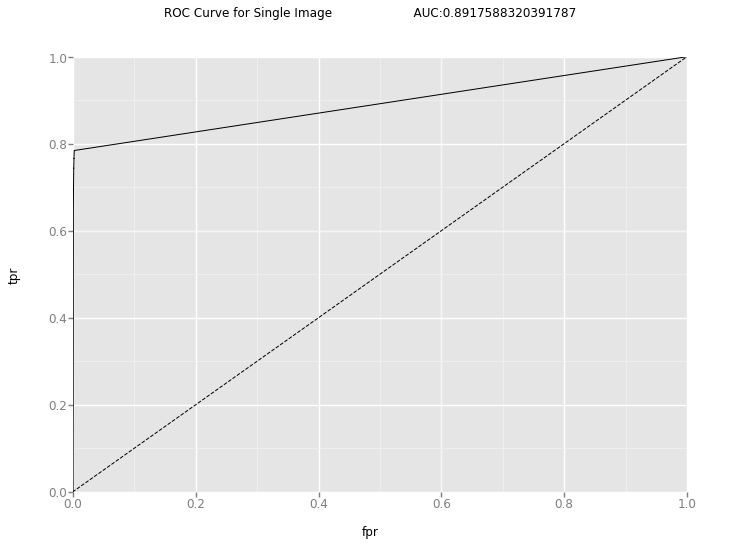

CQS_TBI11428_CT.nii.gz
AUC: 0.8917588320391787
Precision: 0.7433207138994051


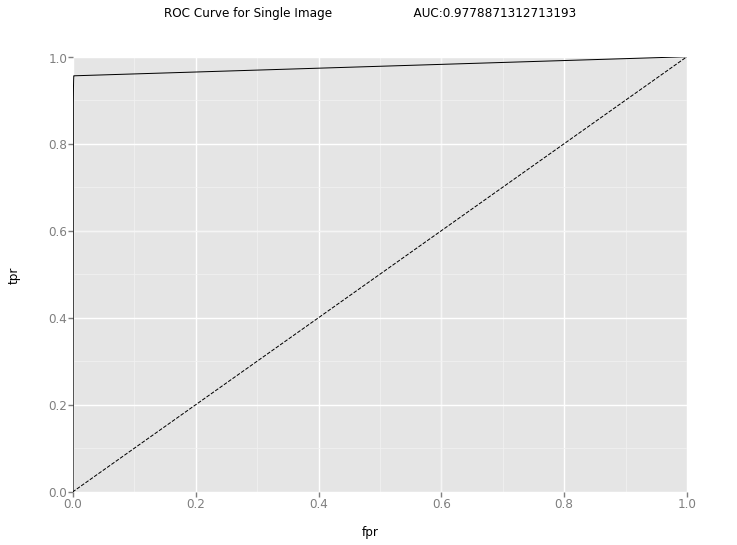

CQS_TBI11456_CT.nii.gz
AUC: 0.9778871312713193
Precision: 0.8480575141711599


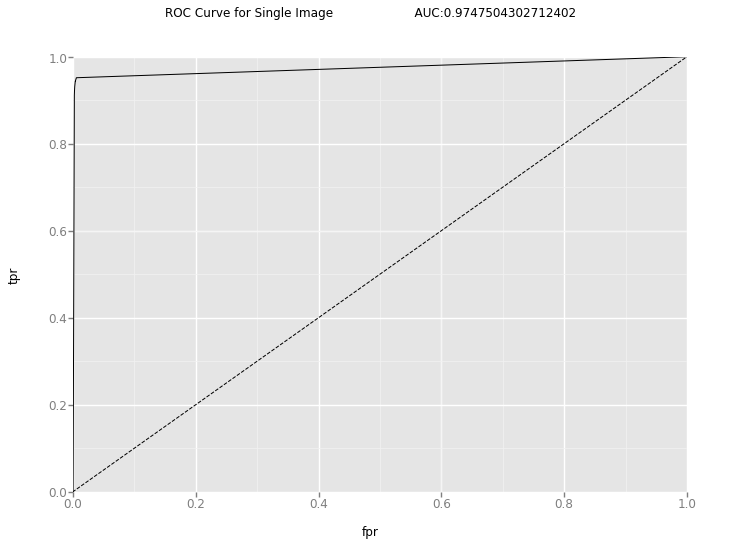

CQS_TBI11578_CT.nii.gz
AUC: 0.9747504302712402
Precision: 0.7470113940601457


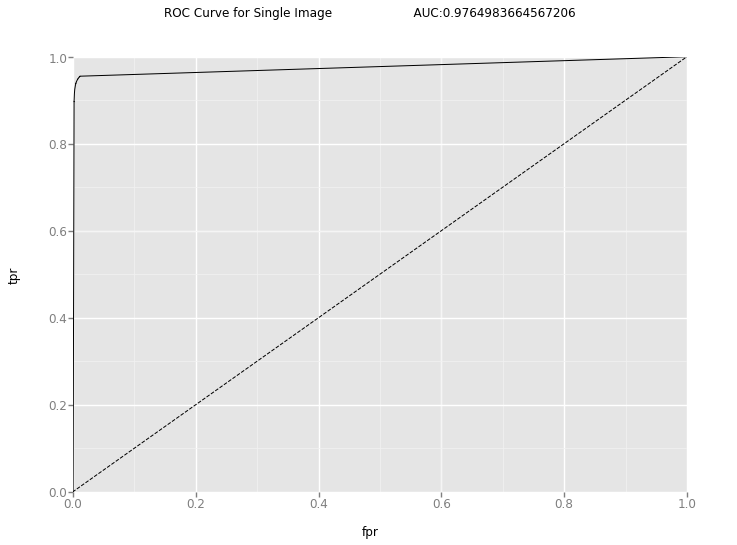

CQS_TBI11699_CT.nii.gz
AUC: 0.9764983664567206
Precision: 0.8470910464676993


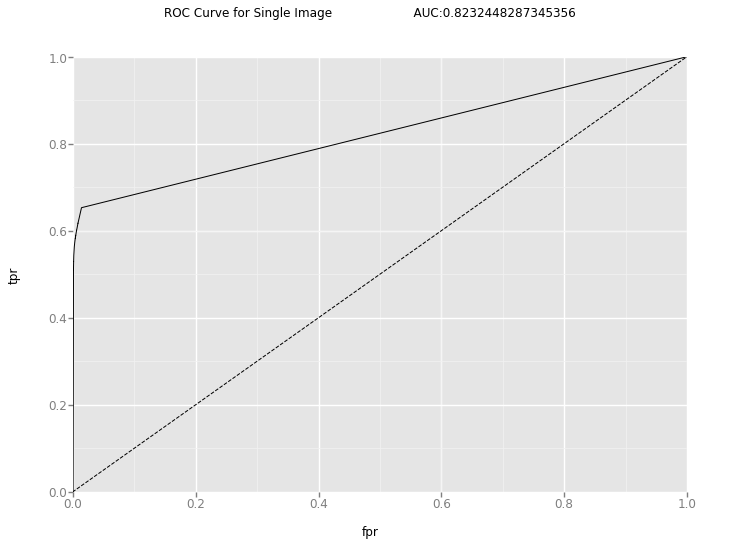

CQS_TBI11767_CT.nii.gz
AUC: 0.8232448287345356
Precision: 0.9290872812671057


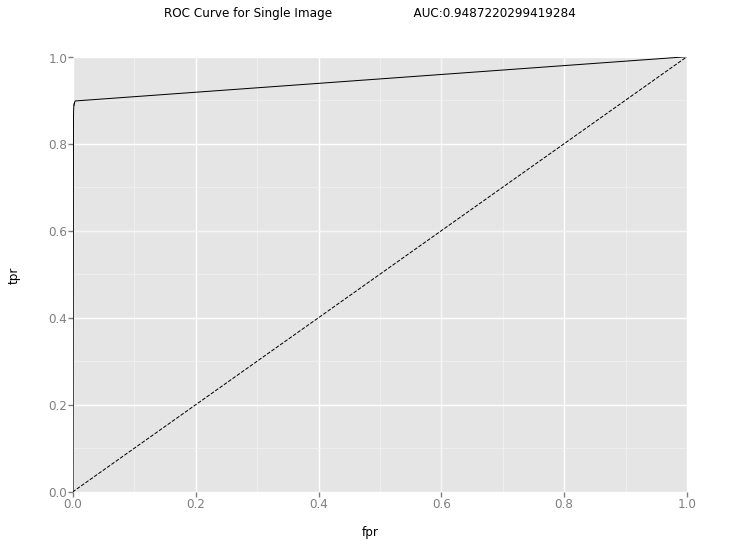

CQS_TBI11915_CT.nii.gz
AUC: 0.9487220299419284
Precision: 0.7448290417897847


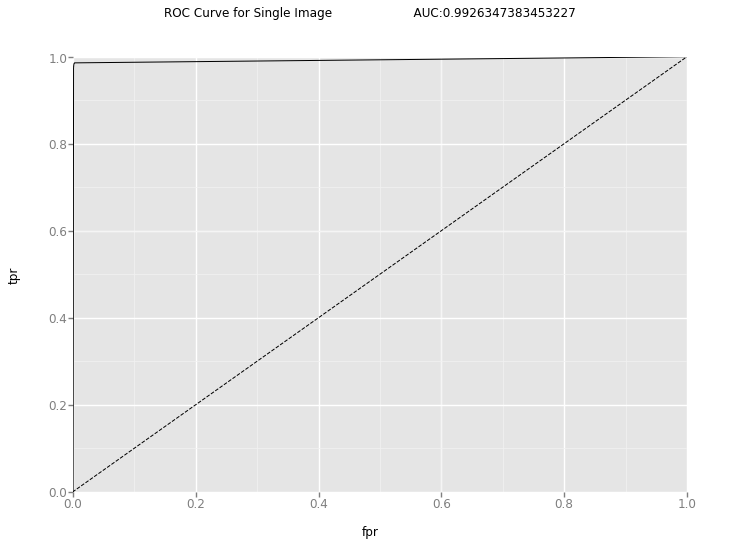

CQS_TBI12018_CT.nii.gz
AUC: 0.9926347383453227
Precision: 0.799735675969836


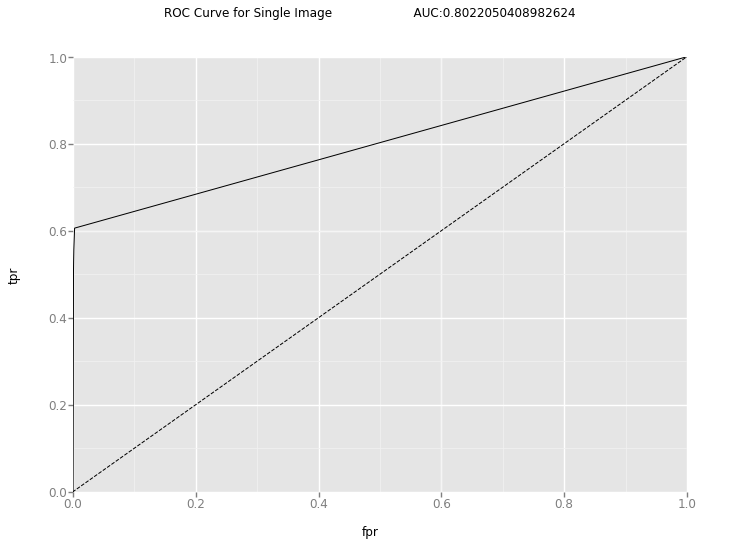

CQS_TBI12035_CT.nii.gz
AUC: 0.8022050408982624
Precision: 0.8689581095596133


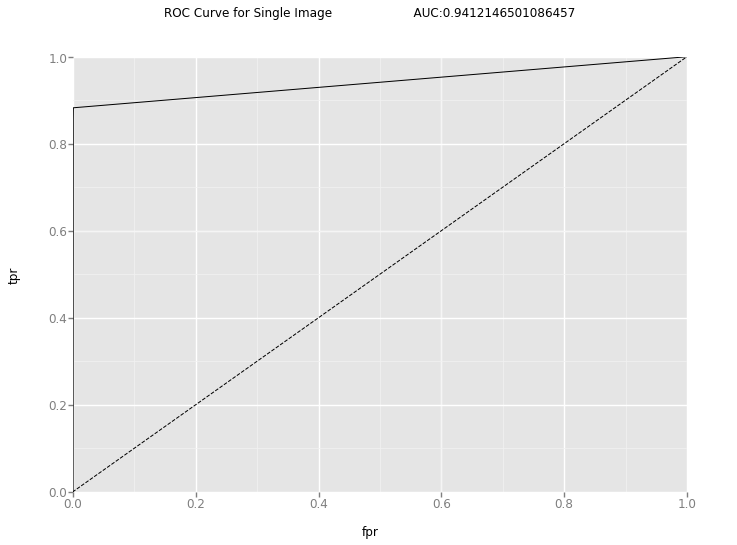

CQS_TBI12161_CT.nii.gz
AUC: 0.9412146501086457
Precision: 0.9229216152019002


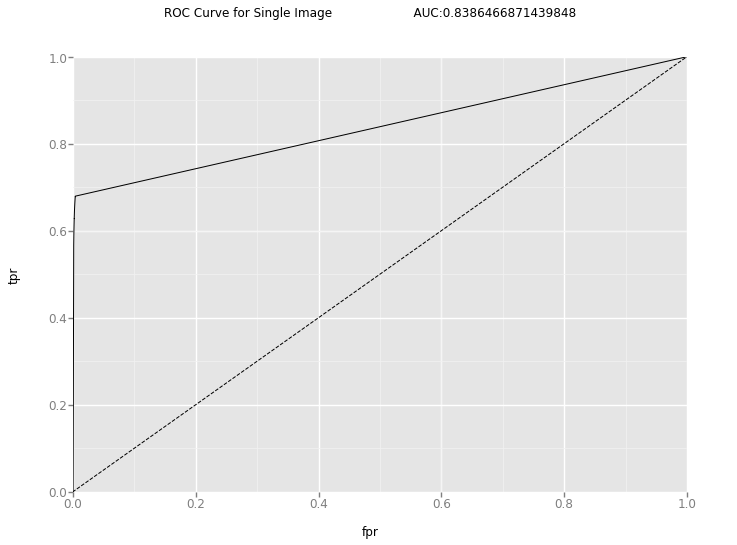

CQS_TBI12238_CT.nii.gz
AUC: 0.8386466871439848
Precision: 0.8388762652344557


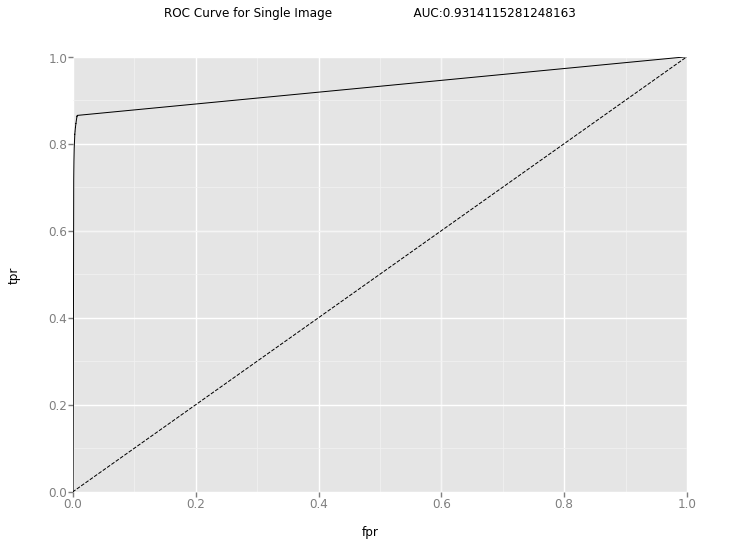

CQS_TBI12516_CT.nii.gz
AUC: 0.9314115281248163


KeyboardInterrupt: 

In [80]:
for pred, gt in zip(pred_filenames, gt_filenames):
    x = nib.load(pred).get_data()
    x_thresh = x.copy()
    x_thresh[np.where(x_thresh >= 0.5)] = 1
    x_thresh[np.where(x_thresh < 0.5)] = 0
    
    x_gt = nib.load(gt).get_data()
    orig_shape = x_gt.shape
    pred_shape = x.shape
    
    shape_diff = x.shape[-1] - x_gt.shape[-1]
    shape_diff = np.abs(shape_diff)
    shape_diff /= 2
    shape_diff = int(shape_diff)
    if shape_diff != 0:
        x = x[:,:,shape_diff:-shape_diff]
        x_thresh = x_thresh[:,:,shape_diff:-shape_diff]
    
    fpr, tpr, _ = metrics.roc_curve(x_gt.flatten(), x.flatten())
    auc = metrics.auc(fpr,tpr)
    
    # visually graph the ROC curve
    
    df_roc = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
    roc_curve = ggplot(df_roc, aes(x='fpr', y='tpr')) +\
            ggtitle('ROC Curve for ' + os.path.basename(pred) + '                     AUC:' + str(auc))+\
            geom_line() +\
            geom_abline(linetype='dashed') +\
            scale_y_continuous(limits=(0,1)) +\
            scale_x_continuous(limits=(0,1))

    roc_curve.show()
    
    print(os.path.basename(pred))
    print("AUC:", auc)
    print("Precision:", metrics.precision_score(x_gt.flatten(), x_thresh.flatten()))
    print()

In [76]:
metrics.precision_score?